# Image similarity estimation using a Siamese Network with a contrastive loss

**Author:** Mehdi<br>
**Date created:** 2021/05/06<br>
**Last modified:** 2022/09/10<br>
**Description:** Similarity learning using a siamese network trained with a contrastive loss.

## Introduction

[Siamese Networks](https://en.wikipedia.org/wiki/Siamese_neural_network)
are neural networks which share weights between two or more sister networks,
each producing embedding vectors of its respective inputs.

In supervised similarity learning, the networks are then trained to maximize the
contrast (distance) between embeddings of inputs of different classes, while minimizing the distance between
embeddings of similar classes, resulting in embedding spaces that reflect
the class segmentation of the training inputs.

## Setup

In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import os
from emnist import extract_training_samples

import zipfile
import shutil
from typing import Tuple, List
from shutil import copyfile

# Data Imports
from tqdm import tqdm
from glob import glob
from tensorflow import data as tfd
from tensorflow import image as tfi

# Data Visualization
#import plotly.express as px
#import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls
import PIL
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils.vis_utils import plot_model

2023-07-10 20:05:22.742171: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 20:05:22.744070: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-10 20:05:22.779489: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-10 20:05:22.780250: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 20:05:23.401727: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
from keras import backend as K
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## Hyperparameters

In [3]:
EPOCHS = 100
BATCH_SIZE = 32
margin = 1  # Margin for contrastive loss.
DIMENSION = 20

In [4]:
# Constants
IMAGE_SIZE = 150 # size of the input image
NUM_CLASSES = 9 # number of classes at the dataset
SPLIT_SIZE = .9 # Define proportion of images used for training

# Random Seed
RANDOM_SEED = 42 # set random seed for reproducibility
tf.random.set_seed(RANDOM_SEED) # set random seed for TensorFlow
np.random.seed(RANDOM_SEED) # set random seed for NumPy

In [5]:
#Load Data
ORIGINAL_TRAIN_DIR = "avgrs_img/train"
ORIGINAL_TEST_DIR = "avgrs_img/test"

https://www.tensorflow.org/tutorials/load_data/images

https://stackoverflow.com/questions/50992702/how-to-format-x-and-y-data-from-imagedatagenerator-in-keras

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  ORIGINAL_TRAIN_DIR,
  color_mode="grayscale", 
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=205,
  )

Found 205 files belonging to 3 classes.


In [7]:
class_names_train = train_ds.class_names
print(class_names_train)

['chris_evans', 'chris_hemsworth', 'mark_ruffalo']


In [8]:
X_train = []
y_train = []
for X, Y in train_ds:
   X_train = np.append(X_train, X)
   y_train = np.append(y_train, Y)
X_train = X_train.astype(int)
y_train = y_train.astype(int)

2023-07-10 20:05:31.286119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [205]
	 [[{{node Placeholder/_0}}]]
2023-07-10 20:05:31.286397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [205]
	 [[{{node Placeholder/_0}}]]


In [9]:
X_train = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE)
print(X_train.shape)

(205, 150, 150)


In [10]:
print(np.unique(y_train))

[0 1 2]


In [11]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  ORIGINAL_TEST_DIR,
  color_mode="grayscale", 
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=63)

Found 63 files belonging to 5 classes.


In [12]:
class_names_test = test_ds.class_names
print(class_names_test)

['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson']


In [13]:
X_test = []
y_test = []
for X, Y in test_ds:
   X_test = np.append(X_test, X)
   y_test = np.append(y_test, Y)
X_test = X_test.astype(int)
y_test = y_test.astype(int)

2023-07-10 20:05:31.728885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [63]
	 [[{{node Placeholder/_4}}]]
2023-07-10 20:05:31.729188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [63]
	 [[{{node Placeholder/_4}}]]


In [14]:
X_test = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE)
print(X_test.shape)

(63, 150, 150)


In [15]:
print(y_train.shape)

(205,)


In [16]:
print(np.unique(y_test))

[0 1 2 3 4]


## Create pairs of images

We will train the model to differentiate between digits of different classes. For
example, digit `0` needs to be differentiated from the rest of the
digits (`1` through `9`), digit `1` - from `0` and `2` through `9`, and so on.
To carry this out, we will select N random images from class A (for example,
for digit `0`) and pair them with N random images from another class B
(for example, for digit `1`). Then, we can repeat this process for all classes
of digits (until digit `9`). Once we have paired digit `0` with other digits,
we can repeat this process for the remaining classes for the rest of the digits
(from `1` until `9`).

In [17]:

def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    min_value = min(y)
    digit_indices = [np.where(y == i)[0] for i in range(min_value, num_classes)]
    
    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1-min_value])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # add a non-matching example
        label2 = random.randint(0,len(np.unique((y)))-1)
        while label2 == label1: 
            label2 = random.randint(0,len(np.unique((y)))-1)


        idx2 = random.choice(digit_indices[label2])
   
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")

In [18]:
# make train pairs
pairs_train, labels_train = make_pairs(X_train, y_train)

# make test pairs
pairs_test, labels_test = make_pairs(X_test, y_test)

We get:

**pairs_train.shape = (60000, 2, 28, 28)**

- We have 60,000 pairs
- Each pair contains 2 images
- Each image has shape `(28, 28)`

Split the training pairs

In [19]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

Split the test pairs

In [20]:
x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]

## Visualize pairs and their labels

In [21]:

def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


Inspect training pairs

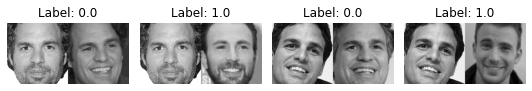

In [22]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

Inspect test pairs

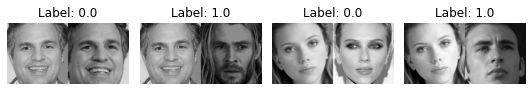

In [23]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

## Define the model

There are two input layers, each leading to its own network, which
produces embeddings. A `Lambda` layer then merges them using an
[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) and the
merged output is fed to the final network.

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                              monitor='val_loss',
                              mode='min',
                              verbose = 1,
                              restore_best_weights=True)
callback=[early_stopping]

In [25]:
# CONTRASTIVE LOSS
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(32, (3,3), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, (3,3), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(DIMENSION, activation="relu")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
input_2 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)

# define model for each loss function
siamese1 = keras.Model(inputs=[input_1, input_2], outputs=output_layer)


In [26]:
# DICE LOSS

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input2 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
x2 = tf.keras.layers.BatchNormalization()(input2)
x2 = layers.Conv2D(32, (3,3), activation="relu")(x2)
x2 = layers.AveragePooling2D(pool_size=(2, 2))(x2)
x2 = layers.Conv2D(32, (3,3), activation="relu")(x2)
x2 = layers.AveragePooling2D(pool_size=(2, 2))(x2)
x2 = layers.Flatten()(x2)
x2 = layers.Dense(32, activation="relu")(x2)
x2 = layers.Dense(DIMENSION, activation="relu")(x2)
embedding_network_2 = keras.Model(input2, x2)


input_1_2 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
input_2_2 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1_2 = embedding_network_2(input_1_2)
tower_2_2 = embedding_network_2(input_2_2)

merge_layer_2 = layers.Lambda(euclidean_distance)([tower_1_2, tower_2_2])
normal_layer_2 = tf.keras.layers.BatchNormalization()(merge_layer_2)
output_layer_2 = layers.Dense(1, activation="sigmoid")(normal_layer_2)
siamese2 = keras.Model(inputs=[input_1_2, input_2_2], outputs=output_layer_2)

In [27]:
# BCE LOSS

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input3 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
x3 = tf.keras.layers.BatchNormalization()(input3)
x3 = layers.Conv2D(32, (3,3), activation="relu")(x3)
x3 = layers.AveragePooling2D(pool_size=(2, 2))(x3)
x3 = layers.Conv2D(32, (3,3), activation="relu")(x3)
x3 = layers.AveragePooling2D(pool_size=(2, 2))(x3)
x3 = layers.Flatten()(x3)
x3 = layers.Dense(32, activation="relu")(x3)
x3 = layers.Dense(DIMENSION, activation="relu")(x3)
embedding_network_3 = keras.Model(input3, x3)

input_1_3 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
input_2_3 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1_3 = embedding_network_3(input_1_3)
tower_2_3 = embedding_network_3(input_2_3)

merge_layer_3 = layers.Lambda(euclidean_distance)([tower_1_3, tower_2_3])
normal_layer_3 = tf.keras.layers.BatchNormalization()(merge_layer_3)
output_layer_3 = layers.Dense(1, activation="sigmoid")(normal_layer_3)
siamese3 = keras.Model(inputs=[input_1_3, input_2_3], outputs=output_layer_3)

In [28]:
# BCE + DICE LOSS

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input4 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
x4 = tf.keras.layers.BatchNormalization()(input4)
x4 = layers.Conv2D(32, (3,3), activation="relu")(x4)
x4 = layers.AveragePooling2D(pool_size=(2, 2))(x4)
x4 = layers.Conv2D(32, (3,3), activation="relu")(x4)
x4 = layers.AveragePooling2D(pool_size=(2, 2))(x4)
x4 = layers.Flatten()(x4)
x4 = layers.Dense(32, activation="relu")(x4)
x4 = layers.Dense(DIMENSION, activation="relu")(x4)
embedding_network_4 = keras.Model(input4, x4)


input_1_4 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
input_2_4 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1_4 = embedding_network_4(input_1_4)
tower_2_4 = embedding_network_4(input_2_4)

merge_layer_4 = layers.Lambda(euclidean_distance)([tower_1_4, tower_2_4])
normal_layer_4 = tf.keras.layers.BatchNormalization()(merge_layer_4)
output_layer_4 = layers.Dense(1, activation="sigmoid")(normal_layer_4)
siamese4 = keras.Model(inputs=[input_1_4, input_2_4], outputs=output_layer_4)

In [29]:
# MSE + KLD + Ranking Loss

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

input5 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
x5 = tf.keras.layers.BatchNormalization()(input5)
x5 = layers.Conv2D(32, (3,3), activation="relu")(x5)
x5 = layers.AveragePooling2D(pool_size=(2, 2))(x5)
x5 = layers.Conv2D(32, (3,3), activation="relu")(x5)
x5 = layers.AveragePooling2D(pool_size=(2, 2))(x5)
x5 = layers.Flatten()(x5)
x5 = layers.Dense(32, activation="relu")(x5)
x5 = layers.Dense(DIMENSION, activation="relu")(x5)
embedding_network5 = keras.Model(input5, x5)


input_1_5 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
input_2_5 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1_5 = embedding_network5(input_1_5)
tower_2_5 = embedding_network5(input_2_5)

merge_layer_5 = layers.Lambda(euclidean_distance)([tower_1_5, tower_2_5])
normal_layer_5 = tf.keras.layers.BatchNormalization()(merge_layer_5)
output_layer_5 = layers.Dense(1, activation="sigmoid")(normal_layer_5)

# define model for each loss function
siamese5 = keras.Model(inputs=[input_1_5, input_2_5], outputs=output_layer_5)


In [30]:
# Hinge loss

def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

input6 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
x6 = tf.keras.layers.BatchNormalization()(input5)
x6 = layers.Conv2D(32, (3,3), activation="relu")(x6)
x6 = layers.AveragePooling2D(pool_size=(2, 2))(x6)
x6 = layers.Conv2D(32, (3,3), activation="relu")(x6)
x6 = layers.AveragePooling2D(pool_size=(2, 2))(x6)
x6 = layers.Flatten()(x6)
x6 = layers.Dense(32, activation="relu")(x6)
x6 = layers.Dense(DIMENSION, activation="relu")(x6)
embedding_network6 = keras.Model(input5, x6)


input_1_6 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))
input_2_6 = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1_6 = embedding_network6(input_1_6)
tower_2_6 = embedding_network6(input_2_6)

merge_layer_6 = layers.Lambda(euclidean_distance)([tower_1_6, tower_2_6])
normal_layer_6 = tf.keras.layers.BatchNormalization()(merge_layer_6)
output_layer_6 = layers.Dense(1, activation="sigmoid")(normal_layer_6)

# define model for each loss function
siamese6 = keras.Model(inputs=[input_1_6, input_2_6], outputs=output_layer_6)


## Define the contrastive Loss

In [31]:

def contrastive_loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )   

        """
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * margin_square + (y_true) * square_pred
        )
        """

    return contrastive_loss


## Define the Dice Loss
Code: https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras

![Dice Loss](./img/Dice_Loss.png)

In [32]:
# Dice Loss
def dice_loss(margin=1): #ignore margin

    smooth=1e-6

    def dice_coef(y_true, y_pred, smooth=100):        
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return dice
    
    def dice_coef_loss(y_true, y_pred):
        return 1 - dice_coef(y_true, y_pred)
    
    return dice_coef_loss

## Define the Binary Cross Entropy Loss
Code: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook

![BCE Loss](./img/BCE_Loss.png)

In [33]:
# BCE_Loss
def BCE_loss(margin=1): #ignore margin

    def binary_cross_entropy_loss(y_true, y_pred):
        BCE =  K.binary_crossentropy(y_true, y_pred)
        return BCE
    
    return binary_cross_entropy_loss

## Define the BCE + Dice Loss
Paper: https://ieeexplore.ieee.org/abstract/document/10023508?casa_token=_zhnKjSaYgYAAAAA:zZ0oLIx6Yoc56OeYEdvdJfwA0FLyQyhg3NNmd8YOUTzPLLgn5hK8ZoJ4UUAwH_9Dn55YLj2fQbk 
Code: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook

![Dice Loss](./img/BCE_Loss.png)
![Dice Loss](./img/Dice_Loss.png)
![Dice Loss](./img/BCE_Dice_Loss.png)

In [34]:
# BCE_Dice_Loss
def BCE_dice_loss(margin=1): #ignore margin

    smooth=1e-6

    def dice_coef_loss(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        
        return dice

    
    def binary_cross_entropy_loss(y_true, y_pred):
        BCE =  K.binary_crossentropy(y_true, y_pred)
        return BCE
    

    def BCE_dice_coef_loss(y_true, y_pred):
        dice_loss = 1 - dice_coef_loss(y_true, y_pred)
        BCE =  binary_cross_entropy_loss(y_true, y_pred)
        Dice_BCE = BCE + dice_loss
        return Dice_BCE
    
    return BCE_dice_coef_loss

## Define the MSE + KLD + Ranking Loss
https://datascience.stackexchange.com/questions/9262/calculating-kl-divergence-in-python

Original Paper: https://dl.acm.org/doi/pdf/10.1145/3597434

In [35]:
# MSE + KLD + Ranking Loss
def MSE_BKLD_Loss():

    def b_kld_l(y_true, y_pred):
        epsilon = 0.00001

        Q = y_true+epsilon
        Q_hut = y_pred+epsilon
        QQ = (Q + Q_hut)/2

        divergence_Q = K.sum(Q*K.log(Q/QQ))
        divergence_Q_hut = K.sum(Q_hut*K.log(Q/QQ))
        divergence = divergence_Q + divergence_Q_hut
        return 1-divergence
    
    def mse_l(y_true, y_pred):
        mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
        return mse
    
    def mse_bkld_l(y_true, y_pred):
        mse = mse_l(y_true, y_pred)
        bkld = b_kld_l(y_true, y_pred)
        mse_bkld = mse+bkld
        return mse_bkld
    
    return mse_bkld_l

## Define Hinge Loss

In [36]:
# Use Keras Hinge Loss

## Compile the model with the contrastive loss

In [37]:
siamese1.compile(loss=contrastive_loss(margin=margin), optimizer="Adam", metrics=["accuracy"])
siamese1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 20)           1337368     ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

## Compile the model with the dice loss

In [38]:
siamese2.compile(loss=dice_loss(margin=margin), optimizer="Adam", metrics=["accuracy"])
siamese2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 20)           1337368     ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

## Compile the model with the BCE loss

In [39]:
siamese3.compile(loss=BCE_loss(margin=margin), optimizer="Adam", metrics=["accuracy"])
siamese3.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_9 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_4 (Functional)           (None, 20)           1337368     ['input_8[0][0]',                
                                                                  'input_9[0][0]']          

## Compile the model with the BCE + dice loss

In [40]:
siamese4.compile(loss=BCE_dice_loss(margin=margin), optimizer="Adam", metrics=["accuracy"])
siamese4.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_12 (InputLayer)          [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           (None, 20)           1337368     ['input_11[0][0]',               
                                                                  'input_12[0][0]']         

## Compile the model with the MSE + KLD + Ranking Loss

In [41]:
siamese5.compile(loss=MSE_BKLD_Loss(), optimizer="Adam", metrics=["accuracy"])
siamese5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_15 (InputLayer)          [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_8 (Functional)           (None, 20)           1337368     ['input_14[0][0]',               
                                                                  'input_15[0][0]']         

## Compile the model with the Hinge loss

In [42]:
siamese6.compile(loss=tf.keras.losses.Hinge(), optimizer="Adam", metrics=["accuracy"])
siamese6.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_18 (InputLayer)          [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_10 (Functional)          (None, 20)           1337368     ['input_17[0][0]',               
                                                                  'input_18[0][0]']        

## Train the models

In [43]:
# Contrastive Loss
history1 = siamese1.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_split=0.2,
    shuffle=True,
    callbacks=callback,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/100


11/11 [==============================] - 7s 531ms/step - loss: 0.2982 - accuracy: 0.4878 - val_loss: 0.5045 - val_accuracy: 0.4756
Epoch 2/100
11/11 [==============================] - 6s 523ms/step - loss: 0.2680 - accuracy: 0.5518 - val_loss: 0.4999 - val_accuracy: 0.4756
Epoch 3/100
11/11 [==============================] - 6s 495ms/step - loss: 0.2508 - accuracy: 0.5854 - val_loss: 0.4863 - val_accuracy: 0.4756
Epoch 4/100
11/11 [==============================] - 5s 493ms/step - loss: 0.2435 - accuracy: 0.5854 - val_loss: 0.4701 - val_accuracy: 0.4756
Epoch 5/100
11/11 [==============================] - 5s 490ms/step - loss: 0.2264 - accuracy: 0.6463 - val_loss: 0.4688 - val_accuracy: 0.4756
Epoch 6/100
11/11 [==============================] - 5s 493ms/step - loss: 0.2169 - accuracy: 0.6372 - val_loss: 0.4109 - val_accuracy: 0.4512
Epoch 7/100
11/11 [==============================] - 5s 493ms/step - loss: 0.1951 - accuracy: 0.7043 - val_loss: 0.4071 - val_accuracy: 0.4512
Epoch 8/100

In [44]:
# Dice Loss
history2 = siamese2.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_split=0.2,
    shuffle=True,
    callbacks=callback,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/100
11/11 [==============================] - 7s 514ms/step - loss: 0.1183 - accuracy: 0.4878 - val_loss: 0.0979 - val_accuracy: 0.5244
Epoch 2/100
11/11 [==============================] - 5s 497ms/step - loss: 0.1164 - accuracy: 0.5091 - val_loss: 0.0988 - val_accuracy: 0.5244
Epoch 3/100
11/11 [==============================] - 5s 497ms/step - loss: 0.1145 - accuracy: 0.5183 - val_loss: 0.0996 - val_accuracy: 0.5366
Epoch 4/100
11/11 [==============================] - 5s 498ms/step - loss: 0.1127 - accuracy: 0.5305 - val_loss: 0.1005 - val_accuracy: 0.5488
Epoch 5/100
11/11 [==============================] - 6s 500ms/step - loss: 0.1071 - accuracy: 0.5854 - val_loss: 0.0999 - val_accuracy: 0.5488
Epoch 6/100
11/11 [==============================] - 6s 500ms/step - loss: 0.1004 - accuracy: 0.6524 - val_loss: 0.0964 - val_accuracy: 0.5610
Epoch 7/100
11/11 [==============================] - 5s 496ms/step - loss: 0.0932 - accuracy: 0.7134 - val_loss: 0.1008 - val_accuracy: 0.5610

In [45]:
# BCE Loss
history3 = siamese3.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_split=0.2,
    shuffle=True,
    callbacks=callback,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/100
11/11 [==============================] - 7s 507ms/step - loss: 0.9295 - accuracy: 0.5000 - val_loss: 11.8683 - val_accuracy: 0.4756
Epoch 2/100
11/11 [==============================] - 5s 489ms/step - loss: 0.8259 - accuracy: 0.5457 - val_loss: 7.0926 - val_accuracy: 0.4756
Epoch 3/100
11/11 [==============================] - 5s 496ms/step - loss: 0.7676 - accuracy: 0.6006 - val_loss: 4.6298 - val_accuracy: 0.4756
Epoch 4/100
11/11 [==============================] - 5s 491ms/step - loss: 0.7699 - accuracy: 0.5884 - val_loss: 4.4667 - val_accuracy: 0.4878
Epoch 5/100
11/11 [==============================] - 5s 495ms/step - loss: 0.7185 - accuracy: 0.6220 - val_loss: 2.1746 - val_accuracy: 0.4756
Epoch 6/100
11/11 [==============================] - 5s 491ms/step - loss: 0.6839 - accuracy: 0.6311 - val_loss: 1.8534 - val_accuracy: 0.5000
Epoch 7/100
11/11 [==============================] - 5s 494ms/step - loss: 0.5811 - accuracy: 0.7226 - val_loss: 1.1793 - val_accuracy: 0.451

In [46]:
# BCE + Dice Loss
history4 = siamese4.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_split=0.2,
    shuffle=True,
    callbacks=callback,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/100
11/11 [==============================] - 7s 509ms/step - loss: 1.2773 - accuracy: 0.5000 - val_loss: 7.3013 - val_accuracy: 0.5244
Epoch 2/100
11/11 [==============================] - 6s 514ms/step - loss: 1.2169 - accuracy: 0.5488 - val_loss: 2.4365 - val_accuracy: 0.5244
Epoch 3/100
11/11 [==============================] - 6s 546ms/step - loss: 1.1325 - accuracy: 0.6006 - val_loss: 2.5885 - val_accuracy: 0.5244
Epoch 4/100
11/11 [==============================] - 6s 541ms/step - loss: 1.0680 - accuracy: 0.6555 - val_loss: 1.6183 - val_accuracy: 0.5122
Epoch 5/100
11/11 [==============================] - 6s 534ms/step - loss: 0.9790 - accuracy: 0.7226 - val_loss: 1.3395 - val_accuracy: 0.5366
Epoch 6/100
11/11 [==============================] - 6s 538ms/step - loss: 0.8992 - accuracy: 0.7835 - val_loss: 1.1002 - val_accuracy: 0.5854
Epoch 7/100
11/11 [==============================] - 6s 534ms/step - loss: 0.8448 - accuracy: 0.8079 - val_loss: 1.0090 - val_accuracy: 0.6220

In [47]:
# MSE + KLD + Ranking Loss
history5 = siamese5.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_split=0.2,
    shuffle=True,
    callbacks=callback,
    batch_size=BATCH_SIZE,
    epochs= EPOCHS,
)

Epoch 1/100
11/11 [==============================] - 8s 559ms/step - loss: 74.8347 - accuracy: 0.4970 - val_loss: -4.3079 - val_accuracy: 0.4756
Epoch 2/100
11/11 [==============================] - 6s 539ms/step - loss: 72.4337 - accuracy: 0.5213 - val_loss: 1.1615 - val_accuracy: 0.4756
Epoch 3/100
11/11 [==============================] - 5s 493ms/step - loss: 70.0734 - accuracy: 0.5610 - val_loss: 8.8801 - val_accuracy: 0.4756
Epoch 4/100
11/11 [==============================] - 5s 488ms/step - loss: 67.7537 - accuracy: 0.6037 - val_loss: 13.2576 - val_accuracy: 0.4512
Epoch 5/100
11/11 [==============================] - 5s 490ms/step - loss: 63.0009 - accuracy: 0.6494 - val_loss: 18.7494 - val_accuracy: 0.4634
Epoch 6/100
11/11 [==============================] - 5s 492ms/step - loss: 62.2493 - accuracy: 0.6616 - val_loss: 32.0958 - val_accuracy: 0.4634
Epoch 7/100
11/11 [==============================] - 5s 491ms/step - loss: 59.2201 - accuracy: 0.7195 - val_loss: 34.5421 - val_accu

In [48]:
# Hinge Loss
history6 = siamese6.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_split=0.2,
    shuffle=True,
    callbacks=callback,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/100
11/11 [==============================] - 8s 577ms/step - loss: 0.9965 - accuracy: 0.4878 - val_loss: 0.9817 - val_accuracy: 0.5244
Epoch 2/100
11/11 [==============================] - 6s 501ms/step - loss: 0.9831 - accuracy: 0.5274 - val_loss: 0.9837 - val_accuracy: 0.5366
Epoch 3/100
11/11 [==============================] - 5s 490ms/step - loss: 0.9737 - accuracy: 0.5762 - val_loss: 0.9738 - val_accuracy: 0.5366
Epoch 4/100
11/11 [==============================] - 6s 538ms/step - loss: 0.9559 - accuracy: 0.5488 - val_loss: 0.9701 - val_accuracy: 0.5366
Epoch 5/100
11/11 [==============================] - 6s 542ms/step - loss: 0.9374 - accuracy: 0.5976 - val_loss: 0.9731 - val_accuracy: 0.5244
Epoch 6/100
11/11 [==============================] - 6s 543ms/step - loss: 0.8958 - accuracy: 0.6921 - val_loss: 0.9668 - val_accuracy: 0.5488
Epoch 7/100
11/11 [==============================] - 6s 534ms/step - loss: 0.8778 - accuracy: 0.7378 - val_loss: 0.9311 - val_accuracy: 0.6098

## Visualize results

In [49]:
def plt_metric(history, metric, title, has_valid=True, x = 0, y = 0):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    axs[x, y].plot(history[metric])
    if has_valid:
        axs[x, y].plot(history["val_" + metric])
        axs[x, y].legend(["train", "validation"], loc="upper left")
    axs[x, y].set_title(title)
    
    for ax in axs.flat:
        ax.set(xlabel="epoch")
        
    axs.flat[0].set(ylabel="accuracy")
    axs.flat[6].set(ylabel="accuracy")
    axs.flat[3].set(ylabel="loss")
    axs.flat[9].set(ylabel="loss")
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()
        
    axs[x,y].set_xlim([0, 100])

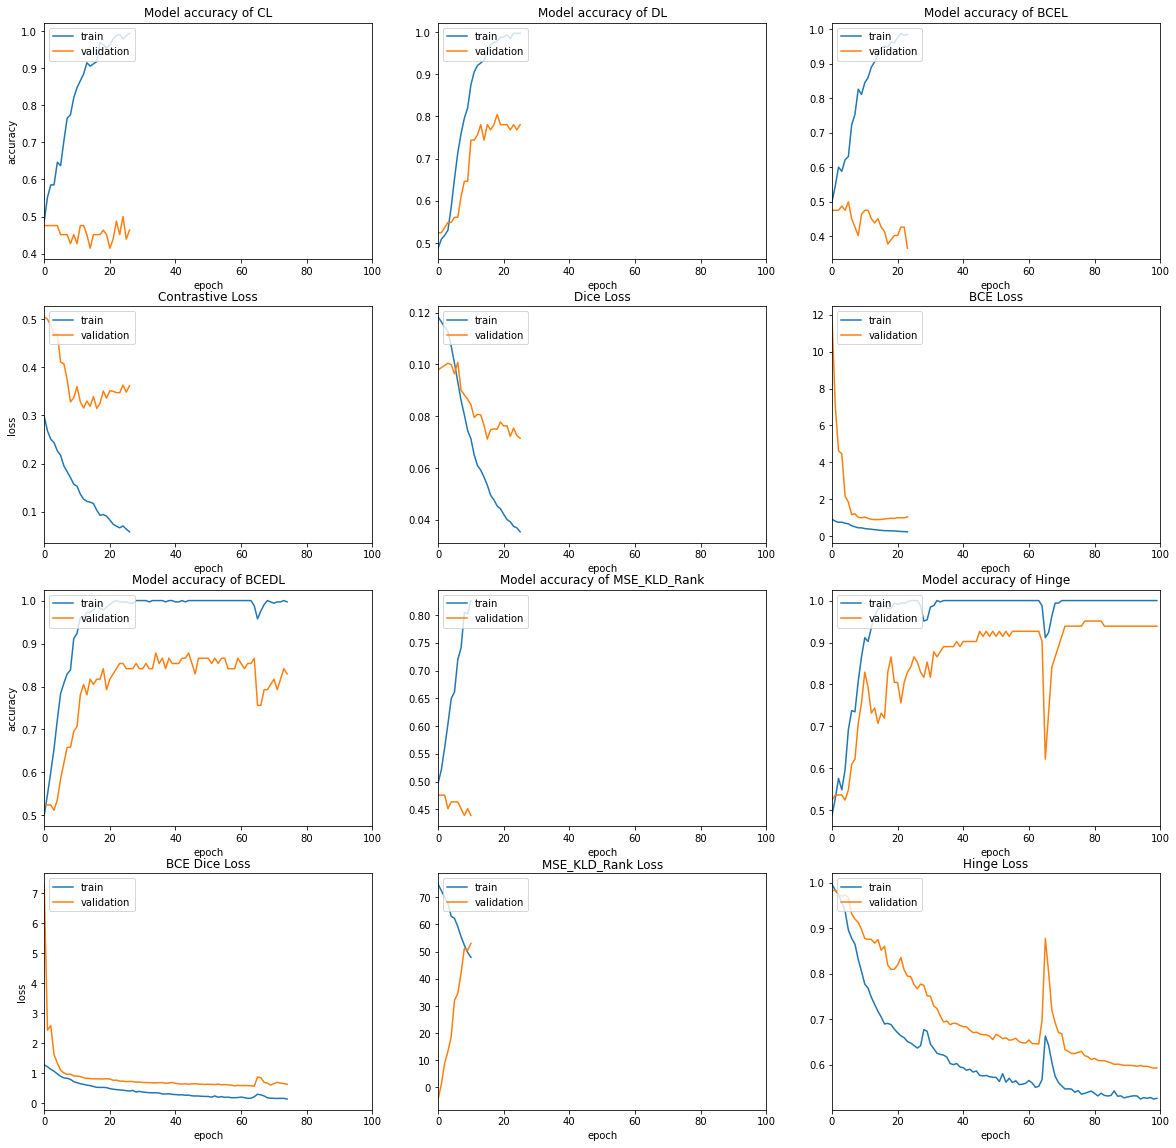

In [50]:
fig, axs = plt.subplots(4, 3)

fig.set_figheight(20)
fig.set_figwidth(20)

# Plot the accuracy of contrastive loss
plt_metric(history=history1.history, metric="accuracy", title="Model accuracy of CL", x=0 ,y=0)

# Plot the contrastive loss
plt_metric(history=history1.history, metric="loss", title="Contrastive Loss", x=1 ,y=0)

# Plot the accuracy of dice loss
plt_metric(history=history2.history, metric="accuracy", title="Model accuracy of DL",x=0 ,y=1)

# Plot the dice loss
plt_metric(history=history2.history, metric="loss", title="Dice Loss", x=1 ,y=1)

# Plot the accuracy of BCE loss
plt_metric(history=history3.history, metric="accuracy", title="Model accuracy of BCEL",x=0 ,y=2)

# Plot the BCE loss
plt_metric(history=history3.history, metric="loss", title="BCE Loss", x=1 ,y=2)

# Plot the accuracy of BCE dice loss
plt_metric(history=history4.history, metric="accuracy", title="Model accuracy of BCEDL", x=2 ,y=0)

# Plot the BCE dice loss
plt_metric(history=history4.history, metric="loss", title="BCE Dice Loss", x=3 ,y=0)

# Plot the accuracy of MSE + KLS + ranking loss
plt_metric(history=history5.history, metric="accuracy", title="Model accuracy of MSE_KLD_Rank", x=2 ,y=1)

# Plot the MSE + KLD + ranking loss
plt_metric(history=history5.history, metric="loss", title="MSE_KLD_Rank Loss", x=3 ,y=1)

# Plot the accuracy of hinge loss
plt_metric(history=history6.history, metric="accuracy", title="Model accuracy of Hinge", x=2 ,y=2)

# Plot the hinge loss
plt_metric(history=history6.history, metric="loss", title="Hinge Loss", x=3 ,y=2)

In [51]:
def plt_metric_train(history, metric, title, has_valid=True, x = 0, y = 0):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    axs[x,y].plot(history[metric])
    
    axs[x,y].legend(["CL","DL","BCEL","BCEDL","Hinge"], loc="upper left")
    
    axs[x,y].set_title(title)
    
    for ax in axs.flat:
        ax.set(xlabel="epoch")
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()  
    
    axs[x,y].set_xlim([0, 100])
            
def plt_metric_val(history, metric, title, has_valid=True, x = 0, y = 0):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    axs[x,y].plot(history["val_" + metric])
    
    axs[x,y].legend(["CL","DL","BCEL","BCEDL","Hinge"], loc="upper left")
    
    axs[x,y].set_title(title)
        
    for ax in axs.flat:
        ax.set(xlabel="epoch")
                        
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()
    
    axs[x,y].set_xlim([0, 100])

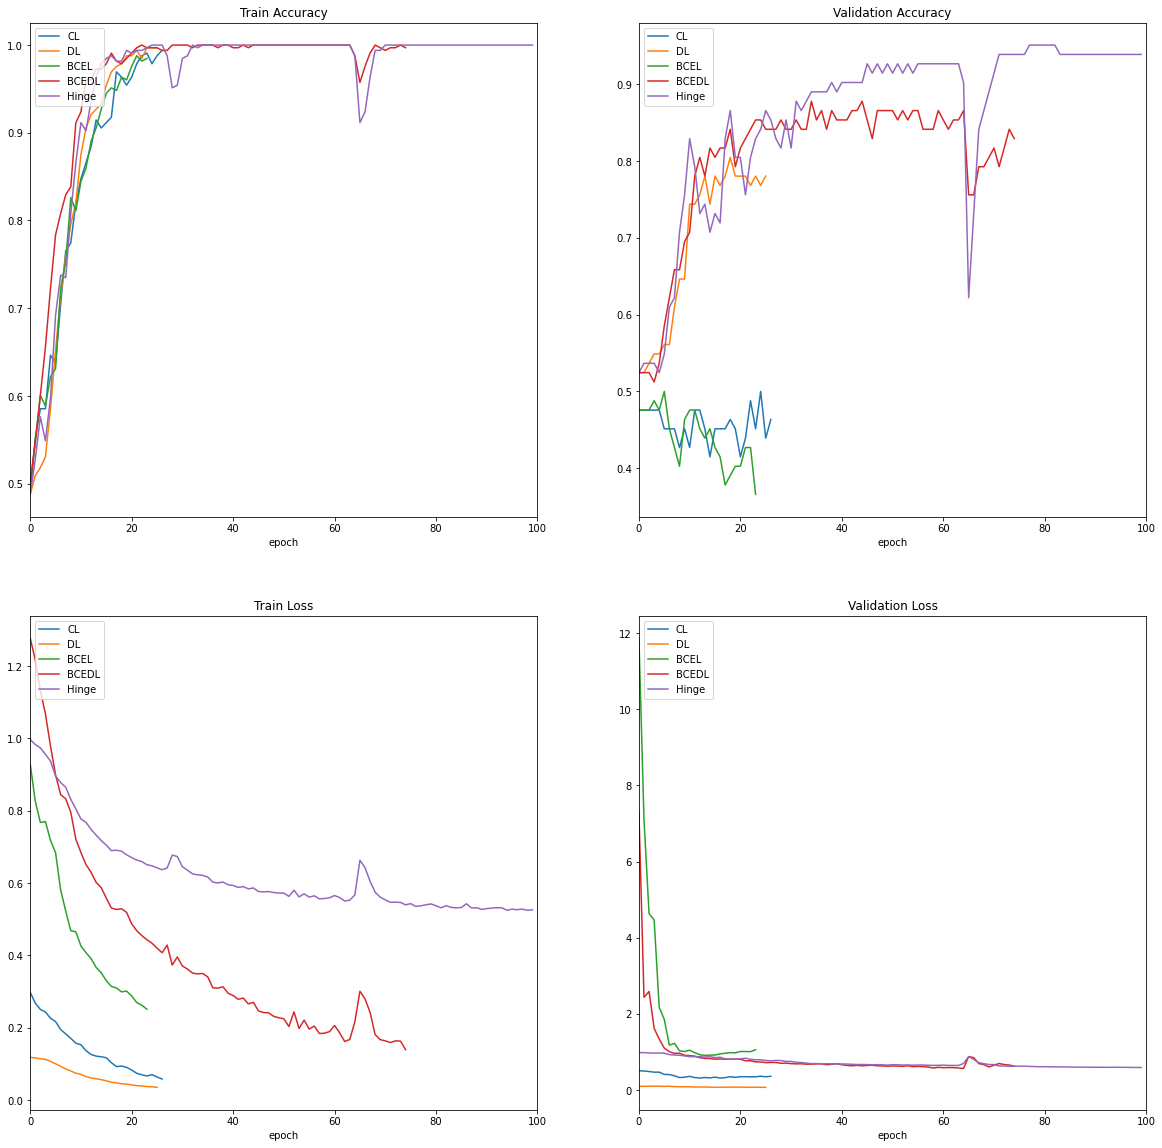

In [68]:
fig, axs = plt.subplots(2,2)

fig.set_figheight(20)
fig.set_figwidth(20)

# Plot the accuracy of contrastive loss
plt_metric_train(history=history1.history, metric="accuracy", title="Train Accuracy", x=0 ,y=0)

# Plot the accuracy of dice loss
plt_metric_train(history=history2.history, metric="accuracy", title="Train Accuracy",x=0 ,y=0)

# Plot the accuracy of BCE loss
plt_metric_train(history=history3.history, metric="accuracy", title="Train Accuracy",x=0 ,y=0)

# Plot the accuracy of BCE dice loss
plt_metric_train(history=history4.history, metric="accuracy", title="Train Accuracy", x=0 ,y=0)

# Plot the accuracy of MSE + KLS + ranking loss
# plt_metric_train(history=history5.history, metric="accuracy", title="Train Accuracy", x=0 ,y=0)

# Plot the accuracy of hinge loss
plt_metric_train(history=history6.history, metric="accuracy", title="Train Accuracy", x=0 ,y=0)


# Plot the contrastive loss
plt_metric_train(history=history1.history, metric="loss", title="Train Loss", x=1 ,y=0)

# Plot the dice loss
plt_metric_train(history=history2.history, metric="loss", title="Train Loss", x=1 ,y=0)

# Plot the BCE loss
plt_metric_train(history=history3.history, metric="loss", title="Train Loss", x=1 ,y=0)

# Plot the BCE dice loss
plt_metric_train(history=history4.history, metric="loss", title="Train Loss", x=1 ,y=0)

# Plot the MSE + KLD + ranking loss
# plt_metric_train(history=history5.history, metric="loss", title="Train Loss", x=1 ,y=0)

# Plot the hinge loss
plt_metric_train(history=history6.history, metric="loss", title="Train Loss", x=1 ,y=0)


# Plot the accuracy of contrastive loss
plt_metric_val(history=history1.history, metric="accuracy", title="Validation Accuracy", x=0 ,y=1)

# Plot the accuracy of dice loss
plt_metric_val(history=history2.history, metric="accuracy", title="Validation Accuracy",x=0 ,y=1)

# Plot the accuracy of BCE loss
plt_metric_val(history=history3.history, metric="accuracy", title="Validation Accuracy",x=0 ,y=1)

# Plot the accuracy of BCE dice loss
plt_metric_val(history=history4.history, metric="accuracy", title="Validation Accuracy", x=0 ,y=1)

# Plot the accuracy of MSE + KLS + ranking loss
# plt_metric_val(history=history5.history, metric="accuracy", title="Validation Accuracy", x=0 ,y=1)

# Plot the accuracy of hinge loss
plt_metric_val(history=history6.history, metric="accuracy", title="Validation Accuracy", x=0 ,y=1)


# Plot the contrastive loss
plt_metric_val(history=history1.history, metric="loss", title="Validation Loss", x=1 ,y=1)

# Plot the dice loss
plt_metric_val(history=history2.history, metric="loss", title="Validation Loss", x=1 ,y=1)

# Plot the BCE loss
plt_metric_val(history=history3.history, metric="loss", title="Validation Loss", x=1 ,y=1)

# Plot the BCE dice loss
plt_metric_val(history=history4.history, metric="loss", title="Validation Loss", x=1 ,y=1)

# Plot the MSE + KLD + ranking loss
#plt_metric_val(history=history5.history, metric="loss", title="Validation Loss", x=1 ,y=1)

# Plot the hinge loss
plt_metric_val(history=history6.history, metric="loss", title="Validation Loss", x=1 ,y=1)


## Evaluate the model

In [53]:
results1 = siamese1.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results1)

4/4 [==============================] - 0s 103ms/step - loss: 0.2892 - accuracy: 0.5317
test loss, test acc: [0.2891952097415924, 0.5317460298538208]


In [54]:
results2 = siamese2.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results2)

4/4 [==============================] - 0s 101ms/step - loss: 0.0982 - accuracy: 0.6825
test loss, test acc: [0.09818441420793533, 0.682539701461792]


In [55]:
results3 = siamese3.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results3)

4/4 [==============================] - 0s 103ms/step - loss: 0.8907 - accuracy: 0.5317
test loss, test acc: [0.89069664478302, 0.5317460298538208]


In [56]:
results4 = siamese4.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results4)

4/4 [==============================] - 0s 109ms/step - loss: 0.9325 - accuracy: 0.7222
test loss, test acc: [0.9325498342514038, 0.7222222089767456]


In [57]:
results5 = siamese5.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results5)

4/4 [==============================] - 0s 105ms/step - loss: -8.8145 - accuracy: 0.5000
test loss, test acc: [-8.81445598602295, 0.5]


In [58]:
results6 = siamese6.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results6)

4/4 [==============================] - 0s 102ms/step - loss: 0.7633 - accuracy: 0.7937
test loss, test acc: [0.7632849216461182, 0.7936508059501648]


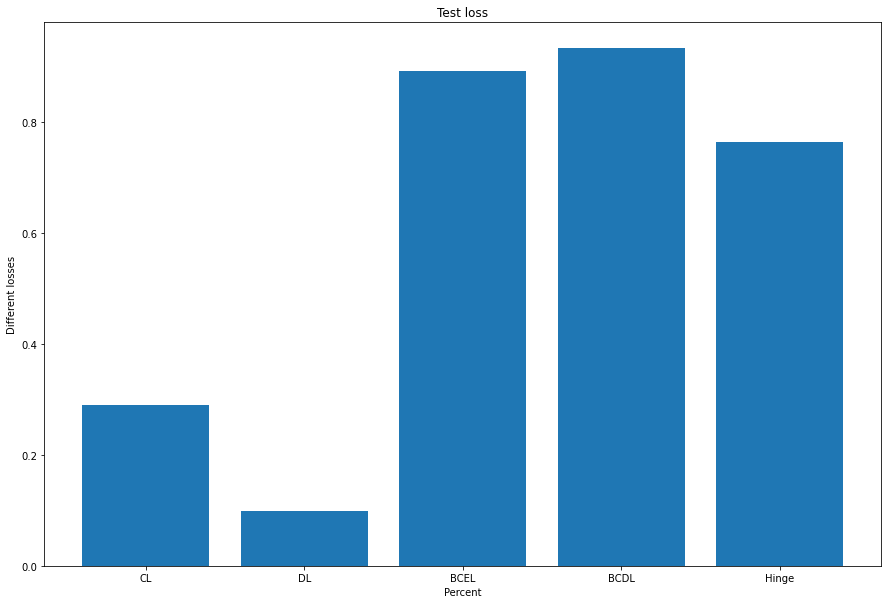

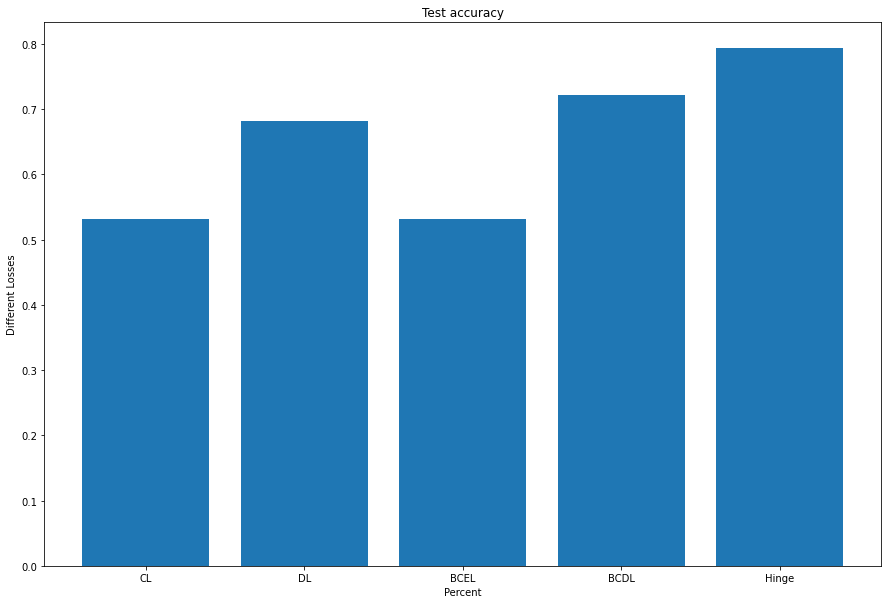

In [69]:
data = {'CL': results1[0], 'DL': results2[0], 'BCEL': results3[0],
        'BCDL': results4[0],'Hinge': results6[0]}
 
courses = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize=(15, 10))
 
# creating the bar plot
plt.bar(courses, values)
 
plt.xlabel("Percent")
plt.ylabel("Different losses")
plt.title("Test loss")
plt.show()

data = {'CL': results1[1], 'DL': results2[1], 'BCEL': results3[1],
        'BCDL': results4[1],
        'Hinge': results6[1]}
 
courses = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize=(15, 10))
 
# creating the bar plot
plt.bar(courses, values)
 
plt.xlabel("Percent")
plt.ylabel("Different Losses")
plt.title("Test accuracy")
plt.show()

In [60]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, recall_score, precision_score, f1_score

# Evaluate the model on the test set
y_pred_cat1 = siamese1.predict([x_test_1, x_test_2])
y_pred1 = np.argmax(y_pred_cat1, axis=1)

report1 = classification_report(labels_test, y_pred1)
print(report1)

4/4 [==============================] - 1s 100ms/step
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67        63
         1.0       0.00      0.00      0.00        63

    accuracy                           0.50       126
   macro avg       0.25      0.50      0.33       126
weighted avg       0.25      0.50      0.33       126



/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:

y_pred_cat2 = siamese2.predict([x_test_1, x_test_2])
y_pred2 = np.argmax(y_pred_cat2, axis=1)

report2 = classification_report(labels_test, y_pred2)
print(report2)


4/4 [==============================] - 1s 99ms/step
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67        63
         1.0       0.00      0.00      0.00        63

    accuracy                           0.50       126
   macro avg       0.25      0.50      0.33       126
weighted avg       0.25      0.50      0.33       126



/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:

y_pred_cat3 = siamese4.predict([x_test_1, x_test_2])
y_pred3 = np.argmax(y_pred_cat3, axis=1)

report3 = classification_report(labels_test, y_pred3)
print(report3)

4/4 [==============================] - 0s 87ms/step
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67        63
         1.0       0.00      0.00      0.00        63

    accuracy                           0.50       126
   macro avg       0.25      0.50      0.33       126
weighted avg       0.25      0.50      0.33       126



/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
y_pred_cat4 = siamese4.predict([x_test_1, x_test_2])
y_pred4 = np.argmax(y_pred_cat4, axis=1)

report4 = classification_report(labels_test, y_pred4)
print(report4)

4/4 [==============================] - 0s 88ms/step
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67        63
         1.0       0.00      0.00      0.00        63

    accuracy                           0.50       126
   macro avg       0.25      0.50      0.33       126
weighted avg       0.25      0.50      0.33       126



/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
y_pred_cat5 = siamese5.predict([x_test_1, x_test_2])
y_pred5 = np.argmax(y_pred_cat5, axis=1)

report5 = classification_report(labels_test, y_pred5)
print(report5)

4/4 [==============================] - 0s 93ms/step
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67        63
         1.0       0.00      0.00      0.00        63

    accuracy                           0.50       126
   macro avg       0.25      0.50      0.33       126
weighted avg       0.25      0.50      0.33       126



/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
y_pred_cat6 = siamese6.predict([x_test_1, x_test_2])
y_pred6 = np.argmax(y_pred_cat5, axis=1)

report6 = classification_report(labels_test, y_pred6)
print(report6)

4/4 [==============================] - 0s 88ms/step
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67        63
         1.0       0.00      0.00      0.00        63

    accuracy                           0.50       126
   macro avg       0.25      0.50      0.33       126
weighted avg       0.25      0.50      0.33       126



/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nd/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


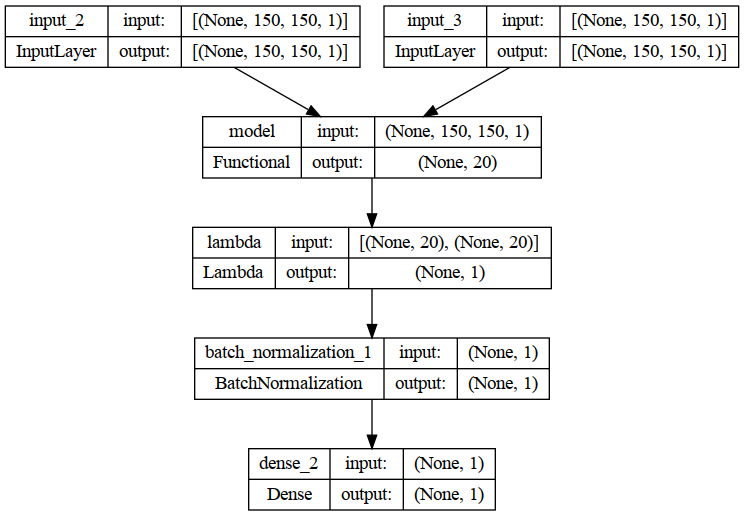

In [67]:
plot_model (siamese1, show_shapes=True, to_file='model.png')

## Visualize the predictions

4/4 [==============================] - 0s 85ms/step


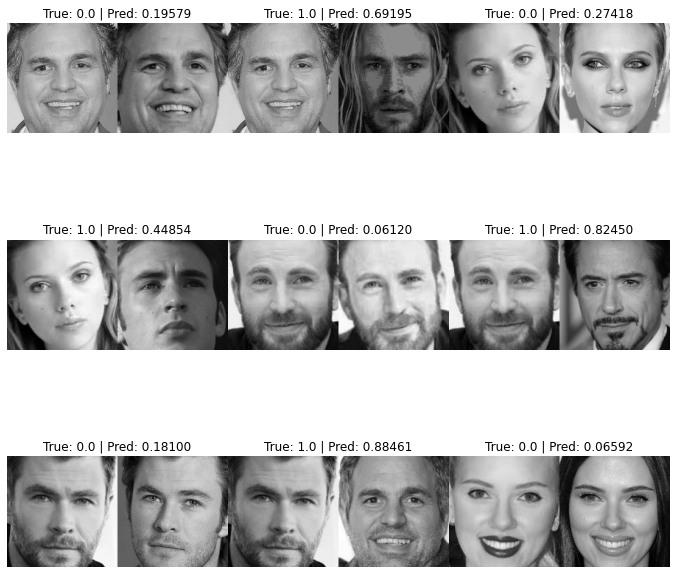

In [ ]:
predictions = siamese1.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=10, predictions=predictions, test=True)

4/4 [==============================] - 0s 86ms/step


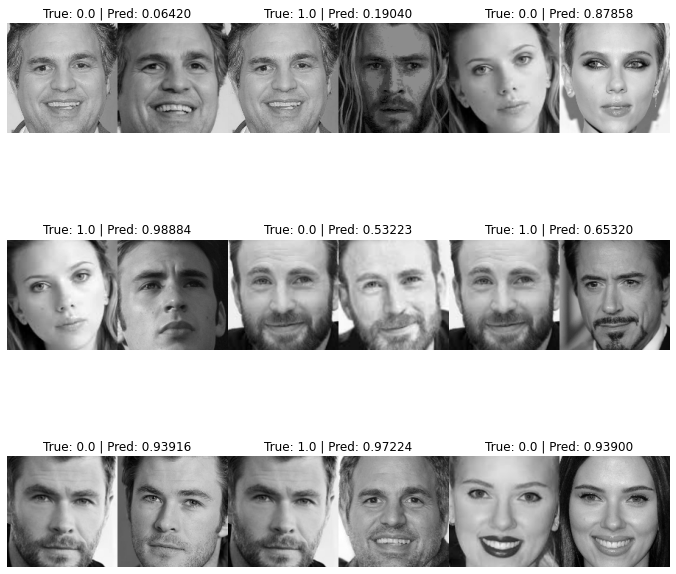

In [ ]:
predictions2 = siamese2.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=10, predictions=predictions2, test=True)

4/4 [==============================] - 0s 86ms/step


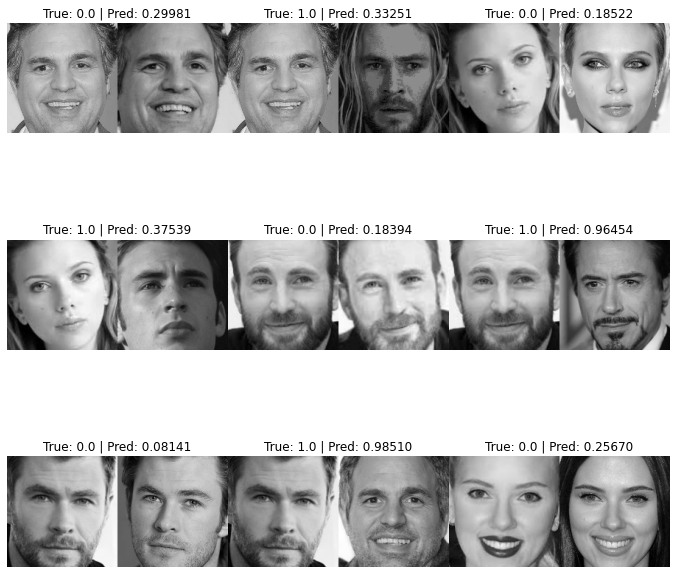

In [ ]:
predictions3 = siamese3.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=10, predictions=predictions3, test=True)

4/4 [==============================] - 0s 85ms/step


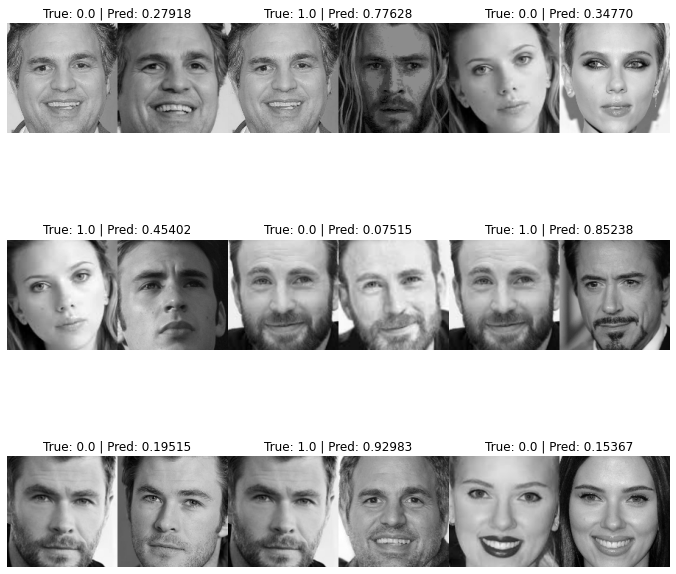

In [ ]:
predictions4 = siamese4.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=10, predictions=predictions4, test=True)

4/4 [==============================] - 0s 85ms/step


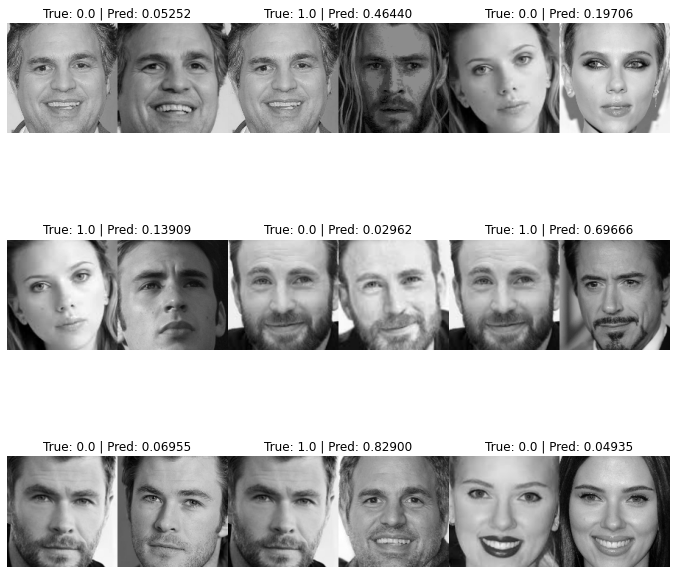

In [ ]:
predictions5 = siamese5.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=10, predictions=predictions5, test=True)

4/4 [==============================] - 0s 85ms/step


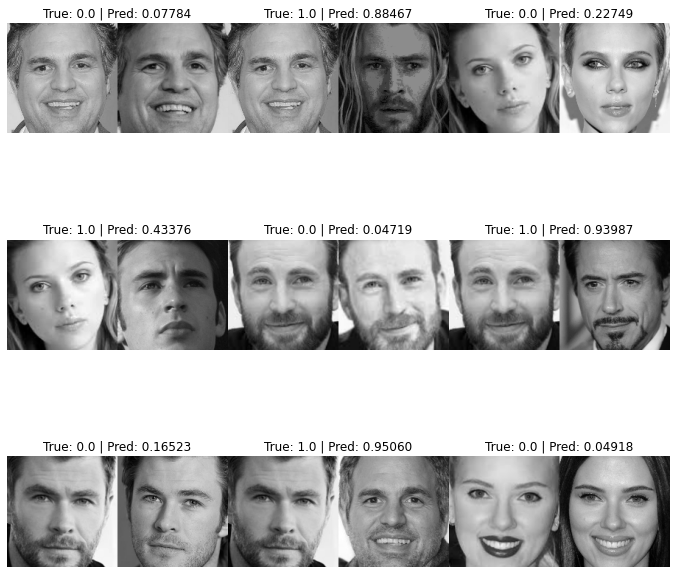

In [ ]:
predictions6 = siamese6.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=10, predictions=predictions6, test=True)

## Other possible loss functions

### Cross Entropy with balance factor (2023)
Paper: 
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10021880 

### Join of MSE, bidirectional Kullback Leibler divergence and rank order of quality scores (2023)
Paper: 
https://dl.acm.org/doi/abs/10.1145/3597434

### Multiple negative ranking loss (2022)
Paper: 
https://arxiv.org/pdf/2203.14541.pdf

original: https://arxiv.org/pdf/1705.00652.pdf

### Max margin hinge loss (2021)
Paper: 
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9414458

### Softmax cross entropy loss (2018)
Paper: 
https://www.researchgate.net/publication/326204812_Modeling_Contemporaneous_Basket_Sequences_with_Twin_Networks_for_Next-Item_Recommendation